# Classical Methods

In [1]:
import os
import cv2
import random
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.utils.data import ConcatDataset, Dataset, DataLoader, random_split

import torch

In [2]:
TRAIN_TEST_SPLIT = (0.8, 0.1) # remaining parts will be test
DIRECTORY_PATH = "/home/mericdemirors/Desktop/TUD_lectures/DLMI/project/project_capsule_dataset"

# best found dataset for set parameters
THRESHOLD = 62859

## Decision Function

In [3]:
# old version of the dataset is used since method was written to be compatible with it during the development time
# USE THE IMPROVED AND COMMENTED LAST VERSION OF THE DATASET FOR ANY OTHER JOB

class BleedDataset(Dataset):
    def __init__(self, root_dir, image_read_func="RGB"):
        self.root_dir = root_dir
        self.bleeding_dir = os.path.join(root_dir, "bleeding")
        self.healthy_dir = os.path.join(root_dir, "healthy")

        # get image paths
        self.x = [os.path.join(self.bleeding_dir, p) for p in os.listdir(self.bleeding_dir)] + [os.path.join(self.healthy_dir, p) for p in os.listdir(self.healthy_dir)]
        
        # get image labels, bleeding=1, healthy=0
        self.y = [1 for _ in os.listdir(self.bleeding_dir)] + [0 for _ in os.listdir(self.healthy_dir)]
        self.num_samples = len(os.listdir(self.bleeding_dir)) + len(os.listdir(self.healthy_dir))

        # set up the function to use for image reading
        # different reading functions can be written and used with this structure
        if image_read_func == "RGB":
            self.image_read_function = self.read_RGB
        elif image_read_func == "gray":
            self.image_read_function = self.read_gray
        else:
            print("Wrong image_read_func parameter")

    def __len__(self):
        return self.num_samples

    def read_RGB(self, idx):
        path = self.x[idx]
        label = self.y[idx]
        
        image = cv2.imread(path)
        image = image[32:544, 32:544] # cropping image to get rid of the black borders
        image[:48,:48] = [0,0,0] # painting the upper left corner if there is a gray square
        image[:31, 452:] = [0,0,0] # painting the upper right corner if there is white text parts
        image = np.transpose(image, [2,0,1]) # adjust the axises into the pytorch dimensions of [B, C, W, H]

        return image, label
    
    def read_gray(self, idx):
        path = self.x[idx]
        label = self.y[idx]
        
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        image = image[32:544, 32:544] # cropping image to get rid of the black borders
        image[:48,:48] = 0 # painting the upper left corner if there is a gray square
        image[:31, 452:] = 0 # painting the upper right corner if there is white text parts
        image = image[np.newaxis, ...] # adjust the axises into the pytorch dimensions of [B, C, W, H]
        
        return image, label

    def __getitem__(self, idx):
        image, label = self.image_read_function(idx)
        return image, label

In [4]:
### ---|---|---|---|---|---|---|---|---|---|--- DATASET SPLIT ---|---|---|---|---|---|---|---|---|---|--- ###
dataset = BleedDataset(DIRECTORY_PATH)

train_size = int(TRAIN_TEST_SPLIT[0] * len(dataset))
test_size = int(TRAIN_TEST_SPLIT[1] * len(dataset))
validation_size = len(dataset) - train_size - test_size

torch.manual_seed(0) # setting the seed to 0 so dataset split is same for every run
train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])
train_validation_dataset = ConcatDataset([train_dataset, validation_dataset])

train_validation_dataloader = DataLoader(train_validation_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [5]:
def image_to_RGB_numpy(image):
    """
    Convert an image from BGR channel order to RGB and transpose its dimensions.

    :param image: Input image in NumPy array format with shape (C, H, W)
    :return: Transformed image in RGB format with shape (H, W, C)
    """
    image = np.transpose(image, (1, 2, 0))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    return image

# Sample images

In [6]:
labels = [l.item() for (_,l) in tqdm(train_validation_dataloader)]

100%|██████████| 6187/6187 [00:37<00:00, 162.92it/s]


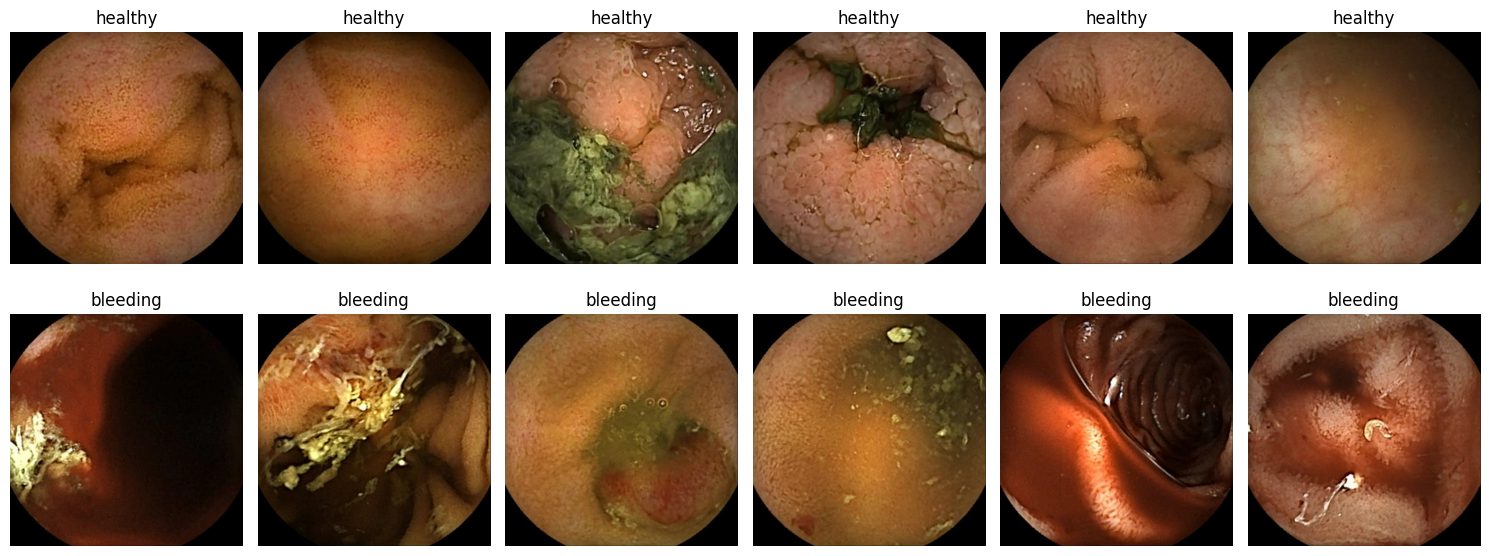

In [17]:
sample_count = 6

zero_indices = [i for i, x in enumerate(labels) if x == 0]
one_indices = [i for i, x in enumerate(labels) if x == 1]

healthy_indices = random.sample(zero_indices, sample_count)
healthy_images = [train_validation_dataset[i][0] for i in healthy_indices]
healthy_images = [image_to_RGB_numpy(image) for image in healthy_images]

bleeding_indices = random.sample(one_indices, sample_count)
bleeding_images = [train_validation_dataset[i][0] for i in bleeding_indices]
bleeding_images = [image_to_RGB_numpy(image) for image in bleeding_images]

fig, axes = plt.subplots(2, sample_count, figsize=(sample_count*2.5, sample_count))

images = healthy_images + bleeding_images
image_labels = [0 for _ in range(sample_count)] + [1 for _ in range(sample_count)]

for e, (ax, image, label) in enumerate(zip(axes.flat, images, image_labels)):
    ax.imshow(image)  # Display the image
    title = {0:'healthy', 1:'bleeding'}
    ax.set_title(f"{title[label]}")  # Add title with label
    ax.axis('off')  # Hide the axes for better visualization

plt.tight_layout()
plt.show()

## Creating Decision Function

In [18]:
def function(image, window_size=18, red_multiplier=5.5, green_multiplier=-9.5, blue_multiplier=-0.5, percentile=10):
    """
    Detect and highlight the most reddish area in an image based on a weighted redness score.

    :param image: Input image in NumPy array format with shape (H, W, C)
    :param window_size: Size of the sliding window for redness evaluation
    :param red_multiplier: Weight for the red channel in the redness score calculation
    :param green_multiplier: Weight for the green channel in the redness score calculation
    :param blue_multiplier: Weight for the blue channel in the redness score calculation
    :param percentile: Percentage of the most reddish pixels to consider for evaluation
    :return: Maximum redness score and the modified image with the highlighted region
    """

    image_rgb = image.astype(np.float32)

    redness_score = image_rgb[:, :, 0] * red_multiplier + image_rgb[:, :, 1] * green_multiplier + image_rgb[:, :, 2] * blue_multiplier

    # remove found spots outside the image
    mask = cv2.imread("mask.png", cv2.IMREAD_GRAYSCALE)

    redness_score = redness_score - np.abs((mask * np.min(redness_score)))

    # Find the top % reddish pixel values
    threshold = np.percentile(redness_score, 100-percentile)
    high_red_indices = np.where(redness_score >= threshold)

    # Initialize variables for the best score and coordinates
    max_score = -np.inf
    best_coords = (0, 0)

    # Calculate window scores only around high redness indices
    h, w = redness_score.shape
    for row, column in zip(*high_red_indices):
        # Define the top-left corner of the window
        top_left_row = max(0, row - window_size // 2)
        top_left_column = max(0, column - window_size // 2)

        # Define the bottom-right corner of the window
        bottom_right_row = min(h, top_left_row + window_size)
        bottom_right_column = min(w, top_left_column + window_size)

        # Extract the window and calculate its redness score
        window = redness_score[top_left_row:bottom_right_row, top_left_column:bottom_right_column]
        score = np.sum(window)

        if score > max_score:
            max_score = score
            best_coords = (row, column)
    
    # Highlight the most reddish area on the image
    image_rgb = image_rgb.astype(np.uint8)
    
    left_upper_column_row = [max(0, best_coords[1] - window_size//2), max(0, best_coords[0] - window_size//2)]
    right_lower_column_row = [min(w, best_coords[1] + window_size//2), min(h, best_coords[0] + window_size//2)]
    cv2.rectangle(image_rgb, left_upper_column_row, right_lower_column_row, (0, 255, 0), 2)

    return max_score, image_rgb

decision_function = function

In [19]:
def try_out_parameters(parameters:list, stop=100):
    """
    Evaluate the performance of a decision function with specified parameters and visualize results.

    :param parameters: Parameters to be passed to the decision function
    :param stop: Number of images to process from the dataloader before stopping
    :return: None
    """
    predictions = []
    for e, (image, _) in tqdm(enumerate(train_validation_dataloader)):
        if e == stop:
            break
        np_image = image.detach().cpu().numpy()[0]
        np_image = image_to_RGB_numpy(np_image)
        decision = decision_function(np_image, *parameters)
        predictions.append(decision)

    colors = ['red' if label == 1 else 'green' for label in labels[:stop]]

    plt.figure(figsize=(30, 15))
    plt.scatter(range(len(predictions)), predictions, c=colors, linewidths=1.5, s=100)

    plt.axhline(y=THRESHOLD, color='blue', linestyle='--', label=f'THTHRESHOLD = {THRESHOLD}')
    plt.title(f"{decision_function.__name__} results with {parameters}", fontsize=20)
    plt.ylabel(f"{decision_function.__name__} output scale", fontsize=20)

    plt.scatter([], [], c='green', edgecolors='none', s=100, label='Healthy (green)')
    plt.scatter([], [], c='red', edgecolors='none', s=100, label='Bleeding (red)')
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

In [20]:
parameter1_values = [18]
parameter2_values = [5.5]
parameter3_values = [-9.5]
parameter4_values = [-0.5]
parameter5_values = [10]
parameter_combinations = list(itertools.product(parameter1_values, parameter2_values, parameter3_values, parameter4_values, parameter5_values))

In [21]:
def save_prediction_plot(predictions:list, par_comb:list):
    """
    Save a scatter plot of prediction results with accuracy metrics.

    :param predictions: List of prediction values from the decision function
    :param par_comb: Parameter combination used for the decision function
    :param total_acc: Overall accuracy of the predictions
    :param healthy_acc: Accuracy for healthy samples
    :param bleeding_acc: Accuracy for bleeding samples
    """
    colors = ['red' if label == 1 else 'green' for label in labels][:len(predictions)]

    plt.figure(figsize=(30, 15))
    plt.scatter(range(len(predictions)), predictions, c=colors, linewidths=1.5, s=100)

    plt.axhline(y=THRESHOLD, color='blue', linestyle='--', label=f'THTHRESHOLD = {THRESHOLD}')
    plt.title(f"{decision_function.__name__} results with {par_comb}", fontsize=20)
    plt.ylabel(f"{decision_function.__name__} output scale", fontsize=20)

    plt.scatter([], [], c='green', edgecolors='none', s=100, label='Healthy (green)')
    plt.scatter([], [], c='red', edgecolors='none', s=100, label='Bleeding (red)')
    plt.scatter([], [], c='none', edgecolors='black', s=100, label='Wrong Prediction (black outline)')
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.savefig(f"{decision_function.__name__} results with {par_comb}.png")

In [22]:
best_accuracy = 0
best_parameter_combination = None
parameter_decisions = []

  0%|          | 24/6187 [00:10<45:51,  2.24it/s]


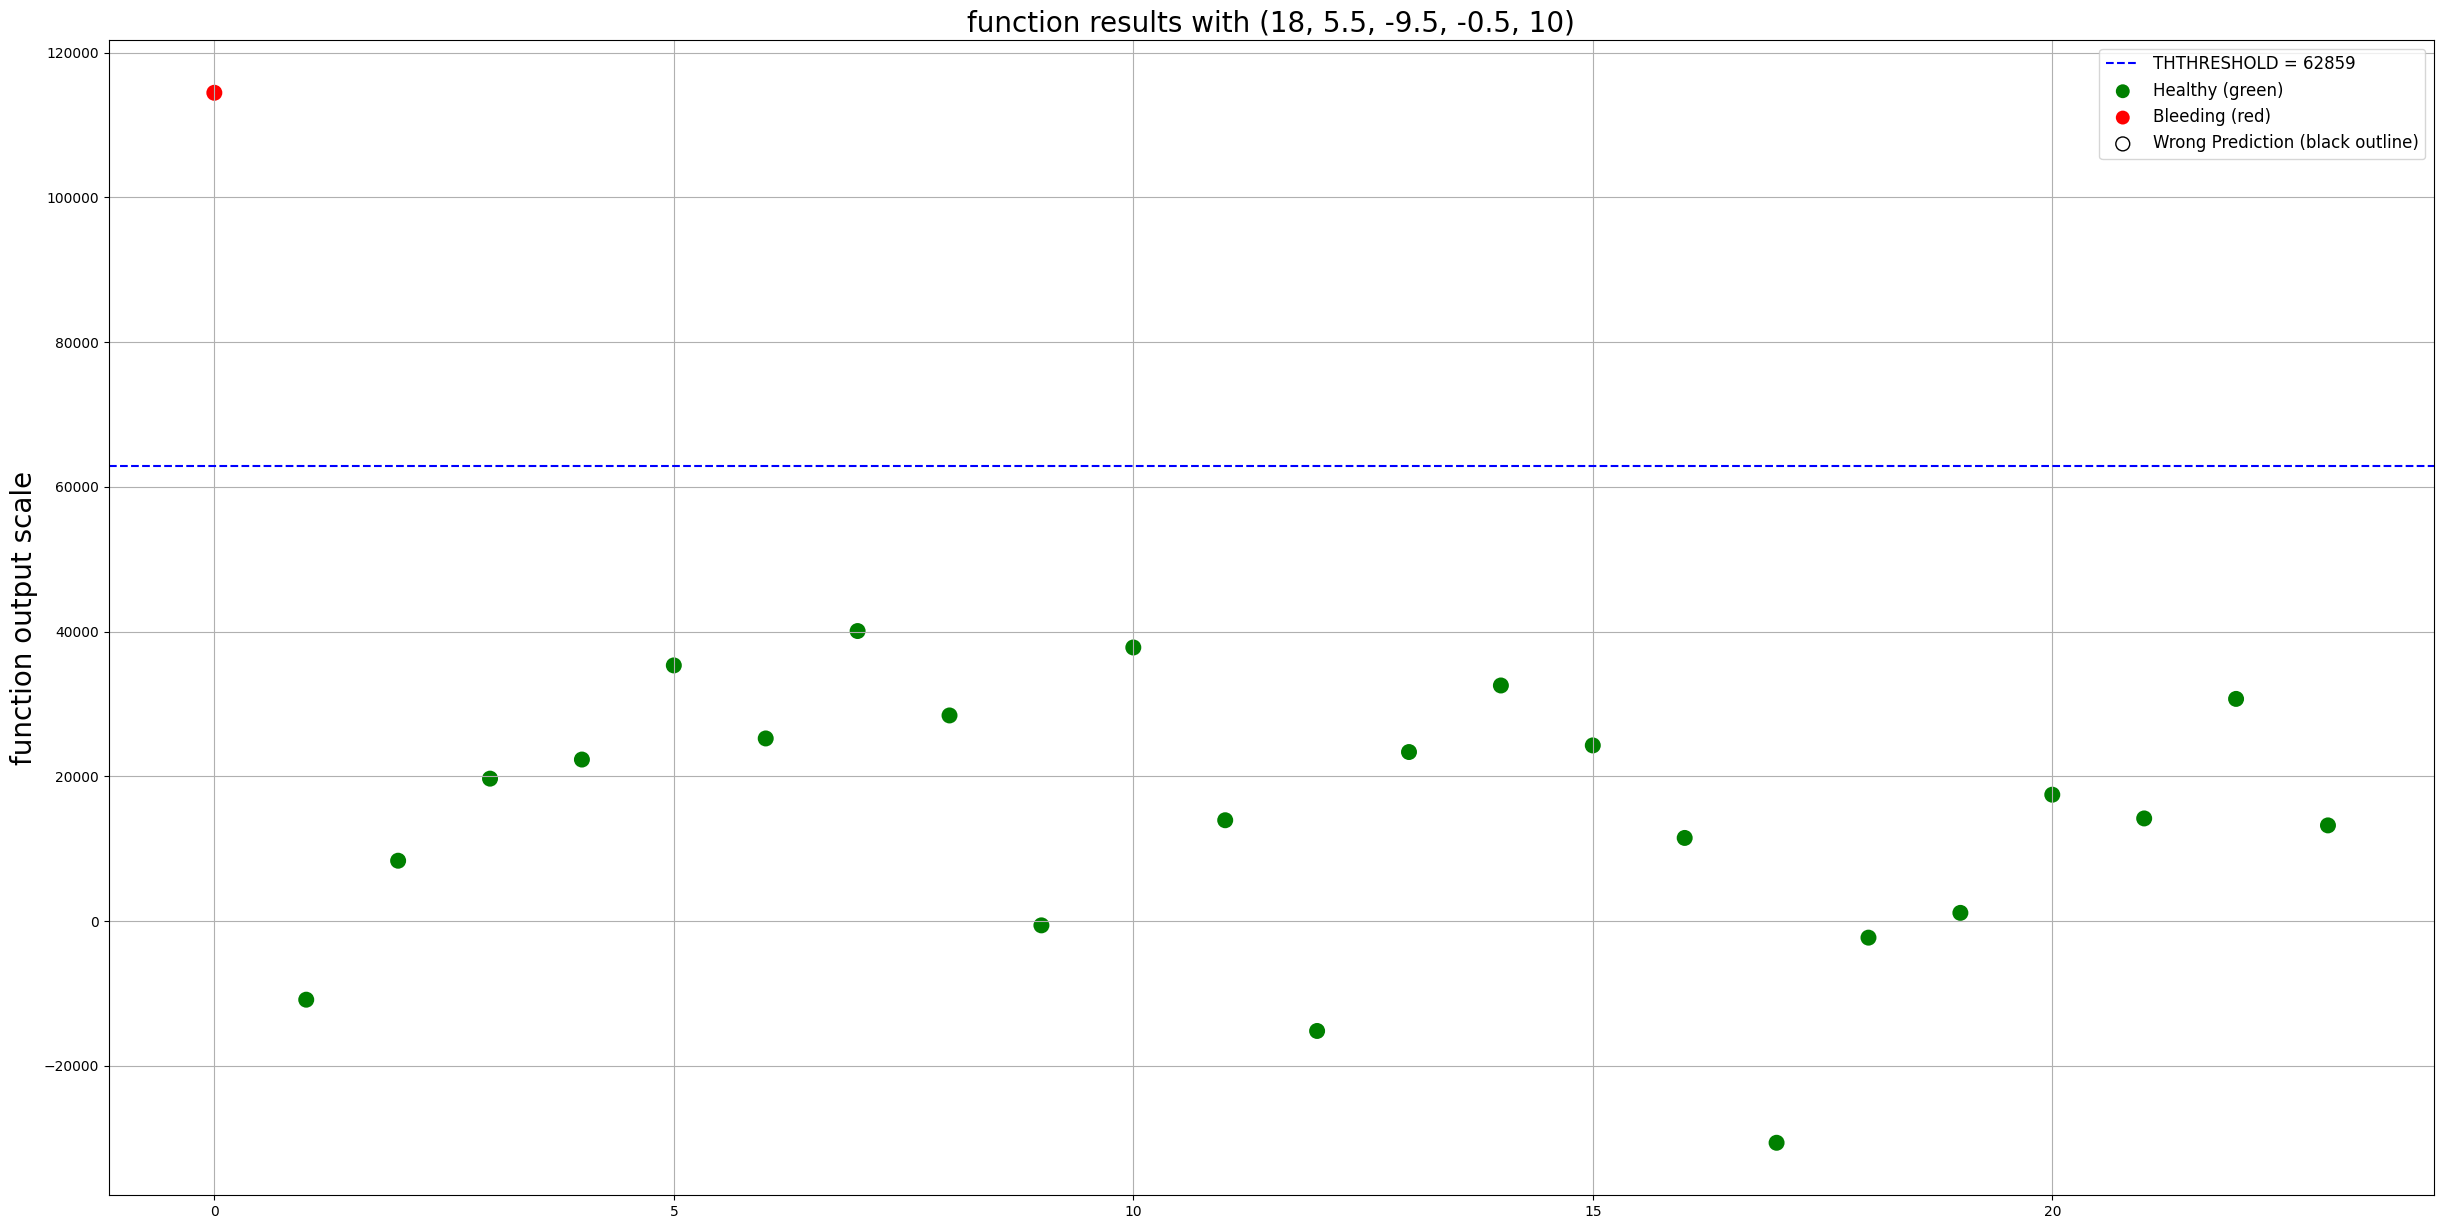

In [23]:
stop = 0
stop_limit = 24
for par_comb in parameter_combinations:
    # class_correct counts how many correct predictions for that label [corrects_for_label_0, corrects_for_label_1]
    # class_total counts how many predictions are there for that label [predictions_for_label_0, predictions_for_label_1]
    class_correct, class_total = [0,0], [0,0]

    parameter_decisions.append([])
    for image, label in tqdm(train_validation_dataloader):
        if stop == stop_limit:
            break
        stop += 1
        np_image = image.detach().cpu().numpy()[0]
        np_image = image_to_RGB_numpy(np_image)
        decision = decision_function(np_image, *par_comb)
        parameter_decisions[-1].append(decision[0])
    
    save_prediction_plot(parameter_decisions[-1], par_comb)

# Rectangles bleeding annotation from the dataset bounding boxes

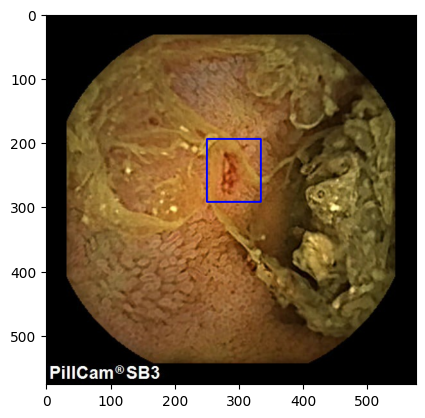

In [24]:
path = "/home/mericdemirors/Desktop/TUD_lectures/DLMI/project/project_capsule_dataset/bleeding/image17968.jpg"
df = pd.read_csv("/home/mericdemirors/Desktop/TUD_lectures/DLMI/project/project_capsule_dataset/bboxes_bleeding.csv")

image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

line = df[df["filename"] == os.path.split(path)[1]].values[0][1:]
xywh = [int(x*576) for x in line]

rectangle_image = cv2.rectangle(image, [xywh[0]-xywh[2]//2,xywh[1]-xywh[3]//2], [xywh[0]+xywh[2]//2, xywh[1]+xywh[3]//2], (0, 0, 255), 2)
plt.imshow(rectangle_image)
plt.show()

# Rectangles the found most red part (image is read from path)

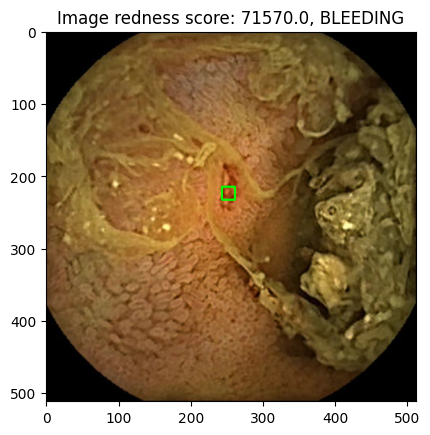

In [25]:
image = cv2.imread(path)
image = image[32:544, 32:544] # cropping image to get rid of the black borders
image[:48,:48] = [0,0,0] # painting the upper left corner if there is a gray square
image[:31, 452:] = [0,0,0] # painting the upper right corner if there is white text parts
image = np.transpose(image, [2,0,1]) # adjust the axises into the pytorch dimensions of [B, C, W, H]
np_image = image_to_RGB_numpy(image)
score, annotated_image = decision_function(np_image, *[18, 5.5, -9.5, -0.5, 10])
plt.imshow(annotated_image)

if score < THRESHOLD:
    plt.title(f"Image redness score: {score}, HEALTHY")
else:
    plt.title(f"Image redness score: {score}, BLEEDING")

plt.show()

# Image comes from dataset

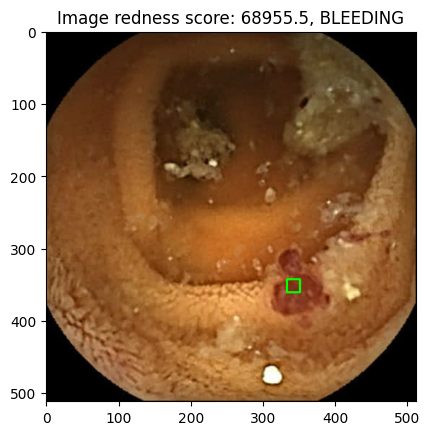

In [26]:
image = train_dataset[443][0]
np_image = image_to_RGB_numpy(image)
score, annotated_image = decision_function(np_image, *[18, 5.5, -9.5, -0.5, 10])
plt.imshow(annotated_image)
if score < THRESHOLD:
    plt.title(f"Image redness score: {score}, HEALTHY")
else:
    plt.title(f"Image redness score: {score}, BLEEDING")